In [ ]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from matplotlib.patches import Rectangle

n = 1000
model = "LGBMClassifier"
base_log_dir = Path("../../yaib_logs")
# log_dir = f'../../../data-addition-dilemma/distance_data'
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'

metric = "ACC_TEST"

hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]

# race_dict = {'race0': 'asian', 'race1': 'black', 'race2': 'other', 'race3': 'white'}
race_dict = {'asian': 'race0', 'black': 'race1', 'other': 'race2', 'white': 'race3'}

hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i
    
format_metric = {'ACC': 'Test Accuracy',
                 'ACC_TEST': 'Test Accuracy',
                 'AUC_TEST': 'Test AUC',
                 'AUC': 'Test AUC'}

In [2]:
# Get patient demographic information, including ethnicity
df_demo = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

df_demo = df_demo.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
df_demo = df_demo.rename(columns={'hospitalid': 'hosp_id'})

df_race = pd.read_csv('demo_data.csv')

## Load Experiment Results

In [3]:
# Base Experiments: Train on 1000 samples from test hospital only
base_avg = np.load(f"../results/base/{model}-n{n}-avg.npz", allow_pickle=True)
base_std = np.load(f"../results/base/{model}-n{n}-std.npz", allow_pickle=True)
base_ci = np.load(f"../results/base/{model}-n{n}-ci.npz", allow_pickle=True)

# Get prediction data for Base Experiments
df_base_rows = [] # store all predictions
df_base = [] # store run results

for i, hos in enumerate(hospital_ids): 
    dir_str = f"train-test{hos}-n{1000}"
    exp_dir = os.path.join(log_dir, dir_str)
    
    # get directory for most recent run
    files = os.listdir(exp_dir)
    files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')] # folders only     
    paths = [os.path.join(exp_dir, basename) for basename in files]
    target_dir = max(paths, key=os.path.getctime)

    for rep in range(5):
        for fold in range(5):
            filename = os.path.join(target_dir, f'repetition_{rep}', f'fold_{fold}', 'patient_results.npz')
            data = np.load(filename)
            
            patient_ids = data["test_ids"]
            predictions = data["predictions"]
            pred_labels = data["pred_labels"]
            true_labels = data["true_labels"]
            
            for pid, pred, pred_label, label in zip(patient_ids, predictions, pred_labels, true_labels):
                df_base_rows.append({
                    "hos_id": hos,
                    "repetition": rep,
                    "fold": fold,
                    "patient_id": pid,
                    "prediction": pred,
                    "pred_label": pred_label,
                    "true_label": label
                })
    
    f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
    result_dict = {'hos_id': hos}
    result_dict.update(json.load(f)['avg'])
    
    df_base.append(result_dict)

df_base_rows = pd.DataFrame(df_base_rows)
df_base = pd.DataFrame(df_base)

# Merge ethnicity data
df = df_base_rows.merge(df_demo[['stay_id', 'ethnic']], left_on='patient_id', right_on='stay_id', how='left')
df = df.drop(columns=['stay_id'])
df = df.dropna(subset='ethnic') # remove rows where ethnicity is unknown

df_temp = df.groupby(by=['hos_id', 'ethnic']).agg(
                pred_mean=('pred_label', 'mean'),
                true_mean=('true_label', 'mean')
            )
df_temp.reset_index(inplace=True)

df_base = df_temp.merge(df_base, on='hos_id')

df_base = df_base[df_base.ethnic != 'asian']

In [4]:
# Add hospital experiments: Train on 1000 samples from test hospital combined with 1000 samples from train hospital 

df_rows = [] # store all predictions
df_base_rows = [] # store run results

for i, test_hos in enumerate(hospital_ids): 
    for j, train_hos in enumerate(hospital_ids):
        
        dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n1000"
        if i == j:
            dir_str = f"train-test{test_hos}-n2000"

        exp_dir = os.path.join(log_dir, dir_str)
        
        # get directory for most recent run
        files = os.listdir(exp_dir)
        files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')] # folders only     
        paths = [os.path.join(exp_dir, basename) for basename in files]
        target_dir = max(paths, key=os.path.getctime)

        for rep in range(5):
            for fold in range(5):
                filename = os.path.join(target_dir, f'repetition_{rep}', f'fold_{fold}', 'patient_results.npz')
                data = np.load(filename)
                
                patient_ids = data["test_ids"]
                predictions = data["predictions"]
                pred_labels = data["pred_labels"]
                true_labels = data["true_labels"]
                
                for pid, pred, pred_label, label in zip(patient_ids, predictions, pred_labels, true_labels):
                    df_rows.append({
                        "test_hos_id": test_hos,
                        "train_hos_id": train_hos,
                        "repetition": rep,
                        "fold": fold,
                        "patient_id": pid,
                        "prediction": pred,
                        "pred_label": pred_label,
                        "true_label": label
                    })
        
        f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
        result_dict = {'test_hos_id': test_hos, 'train_hos_id': train_hos}
        result_dict.update(json.load(f)['avg'])
    
        df_base_rows.append(result_dict)

df_add = pd.DataFrame(df_rows)
df_add_results = pd.DataFrame(df_base_rows)

df_add = df_add.merge(df_demo[['stay_id', 'ethnic']], left_on='patient_id', right_on='stay_id', how='left')
df_add = df_add.drop(columns=['stay_id'])
df_add = df_add.dropna(subset='ethnic') # remove rows where ethnicity is unknown

df_add_temp = df_add.groupby(by=['test_hos_id', 'train_hos_id', 'ethnic']).agg(
                pred_mean=('pred_label', 'mean'),
                true_mean=('true_label', 'mean')
            )
df_add_temp.reset_index(inplace=True)

df_add_results = df_add_temp.merge(df_add_results, on=['test_hos_id', 'train_hos_id'])

df_add_results = df_add_results[df_add_results.ethnic != 'asian']

In [5]:
# Add subgroup experiments: Train on 1000 samples from test hospital combined with all subgroup samples from defined train hospital
add_subgroup_1000_avg = np.load(f"../results/add_subgroup/{model}-n1000-avg.npz", allow_pickle=True)
add_subgroup_1000_std = np.load(f"../results/add_subgroup/{model}-n1000-std.npz", allow_pickle=True)
add_subgroup_1000_ci = np.load(f"../results/add_subgroup/{model}-n1000-ci.npz", allow_pickle=True)

# aggregate results from base experiments to get predictions
df_rows = [] # store all predictions
df_add_rows = [] # store run results

for subgroup in ['black', 'other', 'white']:
    for i, test_hos in enumerate(hospital_ids): 
        for j, train_hos in enumerate(hospital_ids):
            
            dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-{subgroup}-n1000"

            exp_dir = os.path.join(log_dir, dir_str)
            
            # get directory for most recent run
            files = os.listdir(exp_dir)
            files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')] # folders only     
            paths = [os.path.join(exp_dir, basename) for basename in files]
            target_dir = max(paths, key=os.path.getctime)

            for rep in range(5):
                for fold in range(5):
                    filename = os.path.join(target_dir, f'repetition_{rep}', f'fold_{fold}', 'patient_results.npz')
                    data = np.load(filename)
                    
                    patient_ids = data["test_ids"]
                    predictions = data["predictions"]
                    pred_labels = data["pred_labels"]
                    true_labels = data["true_labels"]
                    
                    for pid, pred, pred_label, label in zip(patient_ids, predictions, pred_labels, true_labels):
                        df_rows.append({
                            "test_hos_id": test_hos,
                            "train_hos_id": train_hos,
                            "train_ethnic": subgroup,
                            "repetition": rep,
                            "fold": fold,
                            "patient_id": pid,
                            "prediction": pred,
                            "pred_label": pred_label,
                            "true_label": label
                        })
            
            f = open(os.path.join(target_dir, 'accumulated_test_metrics.json'))
            result_dict = {'test_hos_id': test_hos, 'train_hos_id': train_hos, 'train_ethnic': subgroup}
            result_dict.update(json.load(f)['avg'])
        
            df_add_rows.append(result_dict)

df_add_subg = pd.DataFrame(df_rows)
df_add_subg_results = pd.DataFrame(df_add_rows)

# Merge ethnicity data
df_add_subg = df_add_subg.merge(df_demo[['stay_id', 'ethnic']], left_on='patient_id', right_on='stay_id', how='left')
df_add_subg = df_add_subg.drop(columns=['stay_id'])
df_add_subg = df_add_subg.dropna(subset='ethnic') # remove rows where ethnicity is unknown

df_add_temp = df_add_subg.groupby(by=['test_hos_id', 'train_hos_id', 'train_ethnic', 'ethnic']).agg(
                pred_mean=('pred_label', 'mean'),
                true_mean=('true_label', 'mean')
            )
df_add_temp.reset_index(inplace=True)

df_add_subg_results = df_add_temp.merge(df_add_subg_results, on=['test_hos_id', 'train_hos_id', 'train_ethnic'])
df_add_subg_results = df_add_subg_results[df_add_subg_results['ethnic'] != 'asian']

## Pareto Frontier

In [6]:
base_subg_accuracies = []
base_accuracies = []

for i, row in df_add_subg_results.iterrows():
    test_hos_id = row['test_hos_id']
    test_ethnic = row['ethnic']
    
    test_base_row = df_base[(df_base['hos_id'] == test_hos_id) & (df_base['ethnic'] == test_ethnic)].iloc[0]

    base_accuracies.append(test_base_row[f'{metric}'])
    base_subg_accuracies.append(test_base_row[f'{race_dict[test_ethnic]}_{metric}'])
    
df_add_subg_results[f'{metric}_base'] = pd.Series(base_accuracies)
df_add_subg_results[f'subg_{metric}_base'] = pd.Series(base_subg_accuracies)

In [7]:
#df_add_subg_results_cpy = df_add_subg_results.dropna(subset=['ACC_TEST_base', 'subg_ACC_TEST_base'])
df_add_subg_results_cpy = df_add_subg_results
df_add_subg_results_cpy[f'subg_{metric}'] = df_add_subg_results_cpy.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

df_add_subg_results_cpy[f'{metric}_diff'] = df_add_subg_results_cpy[f'{metric}'] - df_add_subg_results_cpy[f'{metric}_base']
df_add_subg_results_cpy[f'subg_{metric}_diff'] = df_add_subg_results_cpy[f'subg_{metric}'] - df_add_subg_results_cpy[f'subg_{metric}_base']

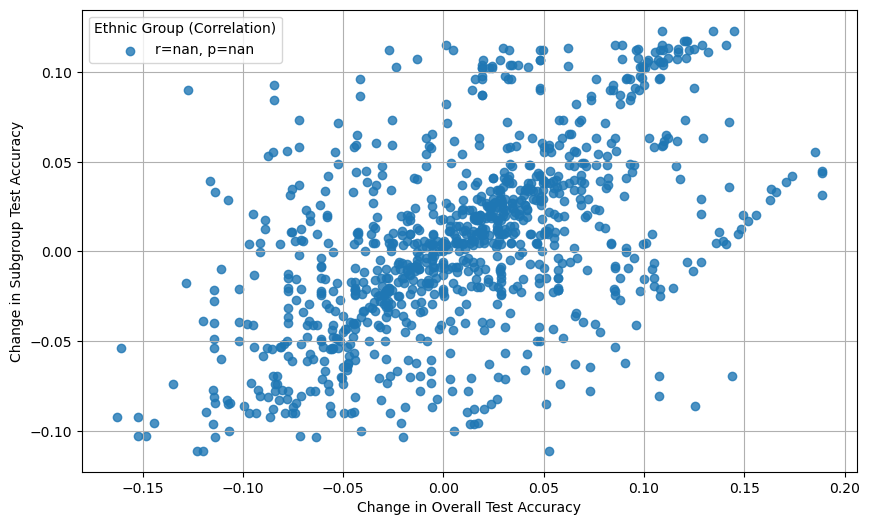

In [8]:
# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))


y_group = df_add_subg_results_cpy[f'{metric}_diff']
x_group = df_add_subg_results_cpy[f'subg_{metric}_diff']
    
# Compute correlation coefficient and p-value
corr_coef, p_val = pearsonr(x_group, y_group)
    
# Add scatter points for the group
plt.scatter(x_group, y_group, label=f"r={corr_coef:.2f}, p={p_val:.2g}", alpha=0.8)

plt.xlabel(f'Change in Overall {format_metric[metric]}')
plt.ylabel(f'Change in Subgroup {format_metric[metric]}')
plt.legend(title='Ethnic Group (Correlation)')
# plt.title('Scatterplot with Correlation by Ethnic Group')
plt.grid(True)
plt.show()

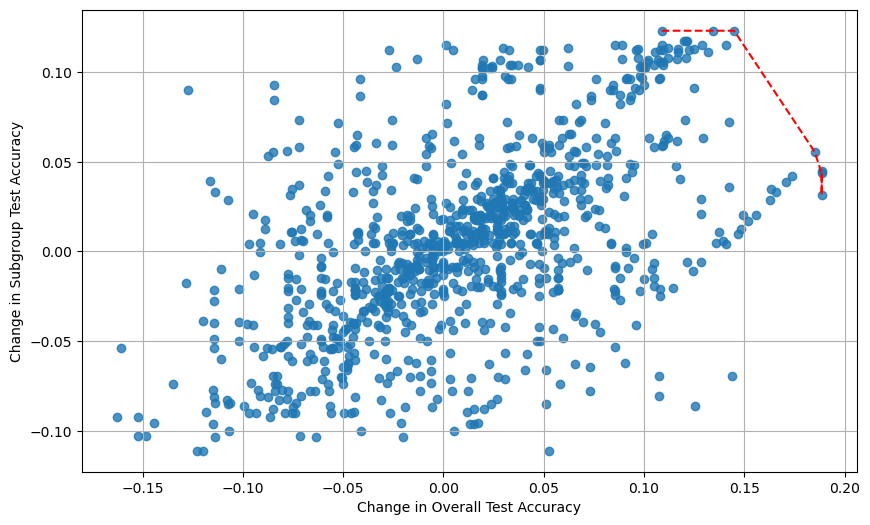

In [9]:
# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))

# Get the data points
y_group = df_add_subg_results_cpy[f'{metric}_diff']
x_group = df_add_subg_results_cpy[f'subg_{metric}_diff']

# Compute correlation coefficient and p-value
corr_coef, p_val = pearsonr(x_group, y_group)

# Add scatter points for the group
plt.scatter(x_group, y_group, label=f"All Points", alpha=0.8)

# Find Pareto frontier points
def is_pareto_efficient(points):
    """
    Find the Pareto-efficient points
    Returns a boolean mask of the points that are Pareto-efficient
    """
    is_efficient = np.ones(points.shape[0], dtype=bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            # Keep any point with a higher x and y
            is_efficient[is_efficient] = np.any(points[is_efficient] > c, axis=1) | np.any(points[is_efficient] == c, axis=1)
            is_efficient[i] = True  # Keep self
    return is_efficient

# Create array of points
points = np.column_stack((x_group, y_group))
pareto_mask = is_pareto_efficient(points)
pareto_points = points[pareto_mask]

# Sort points for plotting
pareto_points = pareto_points[pareto_points[:, 0].argsort()]

# Plot Pareto frontier
plt.plot(pareto_points[:, 0], pareto_points[:, 1], 'r--', label='Pareto Frontier')

plt.xlabel(f'Change in Overall {format_metric[metric]}')
plt.ylabel(f'Change in Subgroup {format_metric[metric]}')
# plt.legend(title='Ethnic Group (Correlation)')
plt.grid(True)
plt.show()

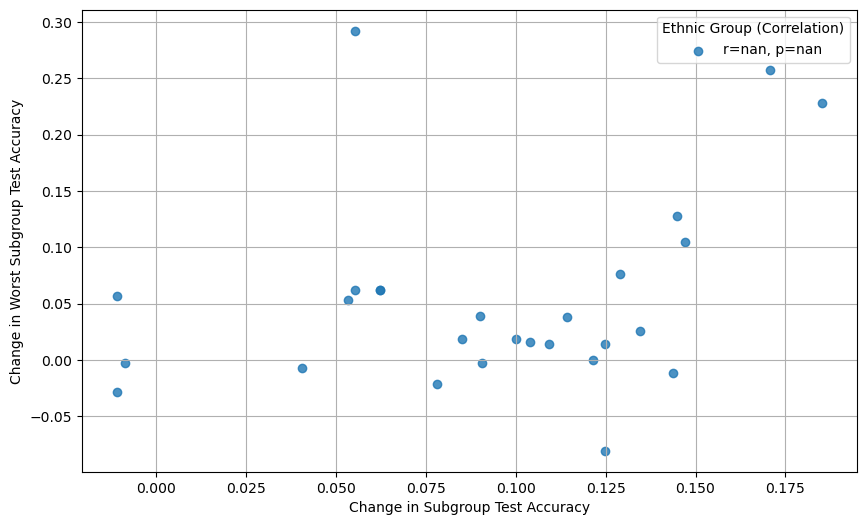

In [10]:
idx = df_add_subg_results_cpy.groupby(['test_hos_id', 'ethnic'])[f'subg_{metric}_diff'].transform(max) == df_add_subg_results_cpy[f'subg_{metric}_diff']

subg_acc_test_diff = df_add_subg_results_cpy[idx][f'subg_{metric}_diff']

worst_subg_acc_post = df_add_subg_results_cpy[idx][[f'race{i}_{metric}' for i in range(4)]].min(axis=1).reset_index(drop=True)
worst_subg_acc_base = df_base[[f'race{i}_{metric}' for i in range(4)]].min(axis=1).reset_index(drop=True)[:27]
worst_subg_acc_diff = worst_subg_acc_post - worst_subg_acc_base

# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))


y_group = worst_subg_acc_diff
x_group = subg_acc_test_diff
    
# Compute correlation coefficient and p-value
corr_coef, p_val = pearsonr(x_group, y_group)
    
# Add scatter points for the group
plt.scatter(x_group, y_group, label=f"r={corr_coef:.2f}, p={p_val:.2g}", alpha=0.8)

plt.xlabel(f'Change in Subgroup {format_metric[metric]}')
plt.ylabel(f'Change in Worst Subgroup {format_metric[metric]}')
plt.legend(title='Ethnic Group (Correlation)')
# plt.title('Scatterplot with Correlation by Ethnic Group')
plt.grid(True)
plt.show()

In [11]:
df_base[f'worst_subg_{metric}_base'] = worst_subg_acc_base

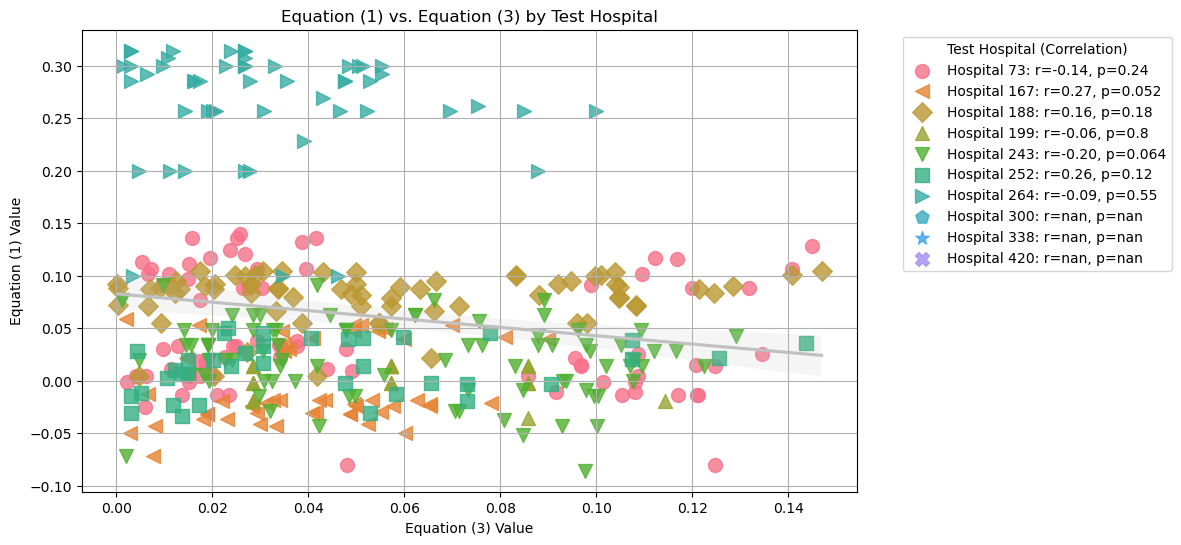

In [12]:
df_use = df_add_subg_results_cpy[df_add_subg_results_cpy[f'subg_{metric}_diff'] > 0]
df_use = df_use.merge(df_base[['hos_id', 'ethnic', f'worst_subg_{metric}_base']], left_on=['test_hos_id', 'ethnic'], right_on=['hos_id', 'ethnic'])
df_use['x_values'] = df_use[f'subg_{metric}_diff']
df_use['y_values'] = df_use[[f'race{i}_{metric}' for i in range(4)]].min(axis=1) - df_use[f'worst_subg_{metric}_base']

# Define 12 unique colors and markers for test_hos_id
test_hosp_ids = df_use['test_hos_id'].unique()
palette = sns.color_palette("husl", 12)  # 12 unique colors
markers = ['o', '<', 'D', '^', 'v', 's', '>', 'p', '*', 'X', 'P', 'h']  # 12 unique markers

# Map each test_hos_id to a color and marker
color_dict = {test_hosp_id: palette[i] for i, test_hosp_id in enumerate(test_hosp_ids)}
marker_dict = {test_hosp_id: markers[i] for i, test_hosp_id in enumerate(test_hosp_ids)}

plt.figure(figsize=(10, 6))
correlation_dict = {}

for test_hos_id in test_hosp_ids:
    mask = df_use['test_hos_id'] == test_hos_id
    x_group = df_use.loc[mask, 'x_values']
    y_group = df_use.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    if len(x_group) > 1:
        corr_coef, p_val = pearsonr(x_group, y_group)
        correlation_dict[test_hos_id] = corr_coef
    else:
        corr_coef, p_val = np.nan, np.nan  # Not enough data points

    plt.scatter(x_group, y_group, 
                label=f"Hospital {test_hos_id}: r={corr_coef:.2f}, p={p_val:.2g}",
                color=color_dict[test_hos_id], 
                marker=marker_dict[test_hos_id], 
                alpha=0.8, s=100)

# Add regression line
sns.regplot(x='x_values', y='y_values', data=df_use, scatter=False, color='silver')

plt.xlabel('Equation (3) Value')
plt.ylabel(f'Equation (1) Value')
plt.legend(title='Test Hospital (Correlation)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.title('Equation (1) vs. Equation (3) by Test Hospital')
plt.grid(True)
plt.show()


## Mean Consistency
Get the mean consistency values for each hospital's base results. Mean consistency is defined as 
$$|\mu_{\mathcal{D}_{a+b}}(a) - \mu_a|$$

Find the relationship between mean consistency and subgroup AUC on $a$.

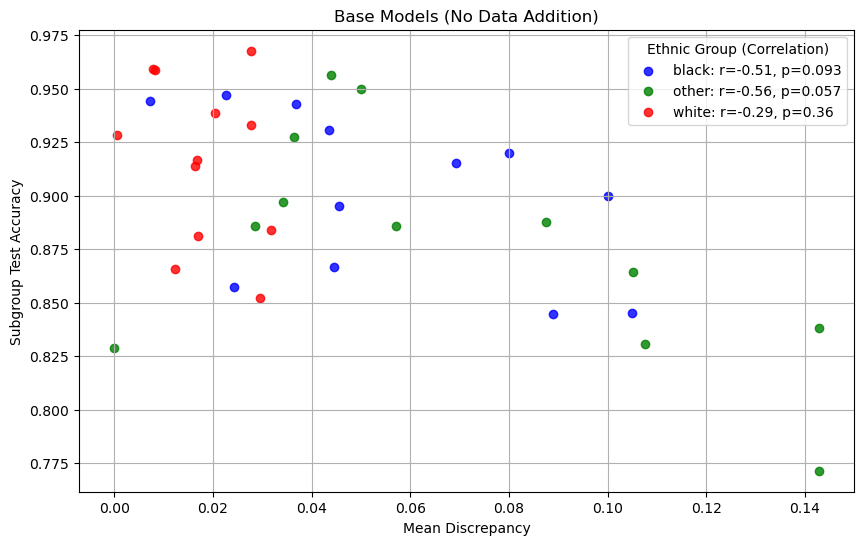

In [13]:
x_values = abs(df_base['pred_mean'] - df_base['true_mean'])
y_values = df_base.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

# Assign unique colors to each ethnic category
categories = df_base['ethnic'].unique()
# colors = {cat: plt.cm.tab10(i) for i, cat in enumerate(categories)}
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))
legend_labels = []

for ethnic_group in categories:
    # Mask for the current ethnic group
    mask = df_base['ethnic'] == ethnic_group
    x_group = x_values[mask]
    y_group = y_values[mask]
    
    # Compute correlation coefficient and p-value
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points for the group
    plt.scatter(x_group, y_group, label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", color=colors[ethnic_group], alpha=0.8)

plt.xlabel('Mean Discrepancy')
plt.ylabel(f"Subgroup {format_metric[metric]}")
plt.legend(title='Ethnic Group (Correlation)')
plt.title('Base Models (No Data Addition)')
plt.grid(True)
plt.show()

### Mean Consistency with Whole Hospital Data Addition

Under data addition, we add source $c$ and train a new classifier $f_{\mathcal{D}_{a+b+c}}$ with mean consistency value
$$|\mu_{\mathcal{D}_{a+b+c}}(a) - \mu_a|$$

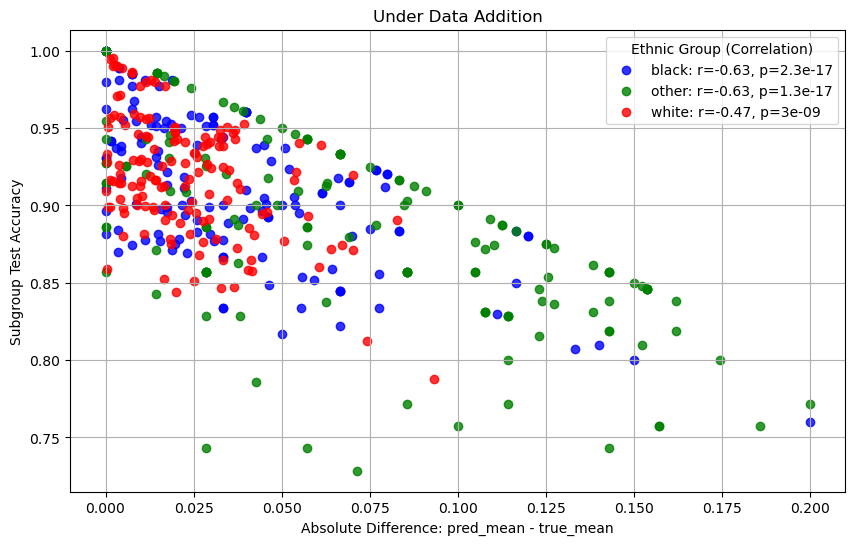

In [14]:
x_values = abs(df_add_results['pred_mean'] - df_add_results['true_mean'])
y_values = df_add_results.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

# Create a filtered DataFrame with no NaN y_values
df_filtered = df_add_results.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

# Assign unique colors to each ethnic category
categories = df_filtered['ethnic'].unique()
# colors = {cat: plt.cm.tab10(i) for i, cat in enumerate(categories)}
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))

for ethnic_group in categories:
    # Mask for the current ethnic group
    mask = df_filtered['ethnic'] == ethnic_group
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points for the group
    plt.scatter(x_group, y_group, label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", color=colors[ethnic_group], alpha=0.8)

plt.xlabel('Absolute Difference: pred_mean - true_mean')
plt.ylabel(f'Subgroup {format_metric[metric]}')
plt.legend(title='Ethnic Group (Correlation)')
plt.title('Under Data Addition')
plt.grid(True)
plt.show()

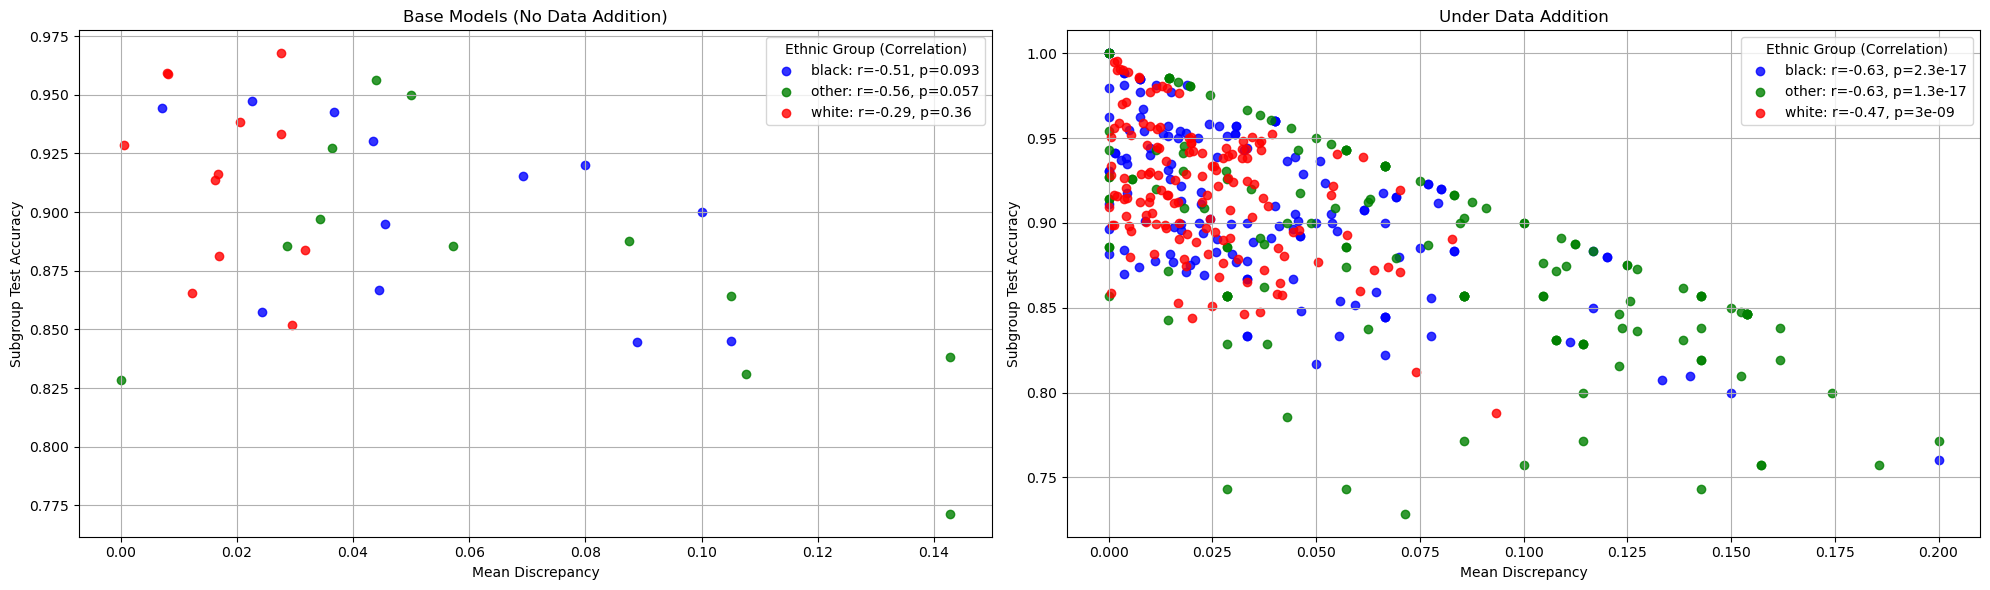

In [15]:
metric = 'ACC_TEST'

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Colors for ethnic groups
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

# First plot - Base Models
x_values = abs(df_base['pred_mean'] - df_base['true_mean'])
y_values = df_base.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

for ethnic_group in df_base['ethnic'].unique():
    mask = df_base['ethnic'] == ethnic_group
    x_group = x_values[mask]
    y_group = y_values[mask]
    
    corr_coef, p_val = pearsonr(x_group, y_group)
    ax1.scatter(x_group, y_group, 
                label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", 
                color=colors[ethnic_group], 
                alpha=0.8)

ax1.set_xlabel('Mean Discrepancy')
ax1.set_ylabel(f"Subgroup {format_metric[metric]}")
ax1.legend(title='Ethnic Group (Correlation)')
ax1.set_title('Base Models (No Data Addition)')
ax1.grid(True)

# Second plot - Data Addition
x_values = abs(df_add_results['pred_mean'] - df_add_results['true_mean'])
y_values = df_add_results.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

df_filtered = df_add_results.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

for ethnic_group in df_filtered['ethnic'].unique():
    mask = df_filtered['ethnic'] == ethnic_group
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    corr_coef, p_val = pearsonr(x_group, y_group)
    ax2.scatter(x_group, y_group, 
                label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", 
                color=colors[ethnic_group], 
                alpha=0.8)

ax2.set_xlabel('Mean Discrepancy')
ax2.set_ylabel(f'Subgroup {format_metric[metric]}')
ax2.legend(title='Ethnic Group (Correlation)')
ax2.set_title('Under Data Addition')
ax2.grid(True)

plt.tight_layout()
plt.show()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

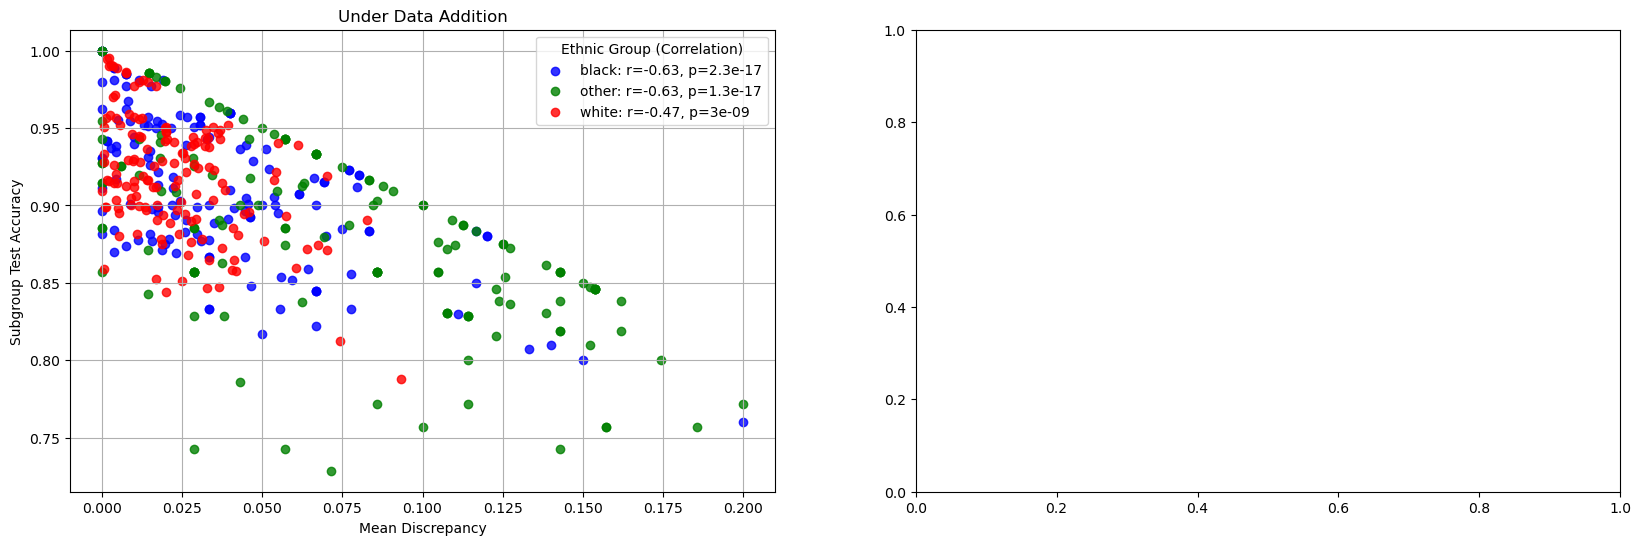

In [16]:
# Create figure with two subplots side by side
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(20, 6))

# Colors for ethnic groups
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

# Second plot - Data Addition
x_values = abs(df_add_results['pred_mean'] - df_add_results['true_mean'])
y_values = df_add_results.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

df_filtered = df_add_results.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

for ethnic_group in df_filtered['ethnic'].unique():
    mask = df_filtered['ethnic'] == ethnic_group
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    corr_coef, p_val = pearsonr(x_group, y_group)
    ax2.scatter(x_group, y_group, 
                label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", 
                color=colors[ethnic_group], 
                alpha=0.8)

ax2.set_xlabel('Mean Discrepancy')
ax2.set_ylabel(f'Subgroup {format_metric[metric]}')
ax2.legend(title='Ethnic Group (Correlation)')
ax2.set_title('Under Data Addition')
ax2.grid(True)

# First plot - Base Models
x_values = x_values - abs(df_base['pred_mean'] - df_base['true_mean'])
y_values = y_values - df_base.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

for ethnic_group in df_base['ethnic'].unique():
    mask = df_base['ethnic'] == ethnic_group
    x_group = x_values[mask]
    y_group = y_values[mask]
    
    corr_coef, p_val = pearsonr(x_group, y_group)
    ax1.scatter(x_group, y_group, 
                label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", 
                color=colors[ethnic_group], 
                alpha=0.8)

ax1.set_xlabel('Mean Discrepancy')
ax1.set_ylabel(f"Subgroup {format_metric[metric]}")
ax1.legend(title='Ethnic Group (Correlation)')
ax1.set_title('Base Models (No Data Addition)')
ax1.grid(True)

plt.tight_layout()
plt.show()

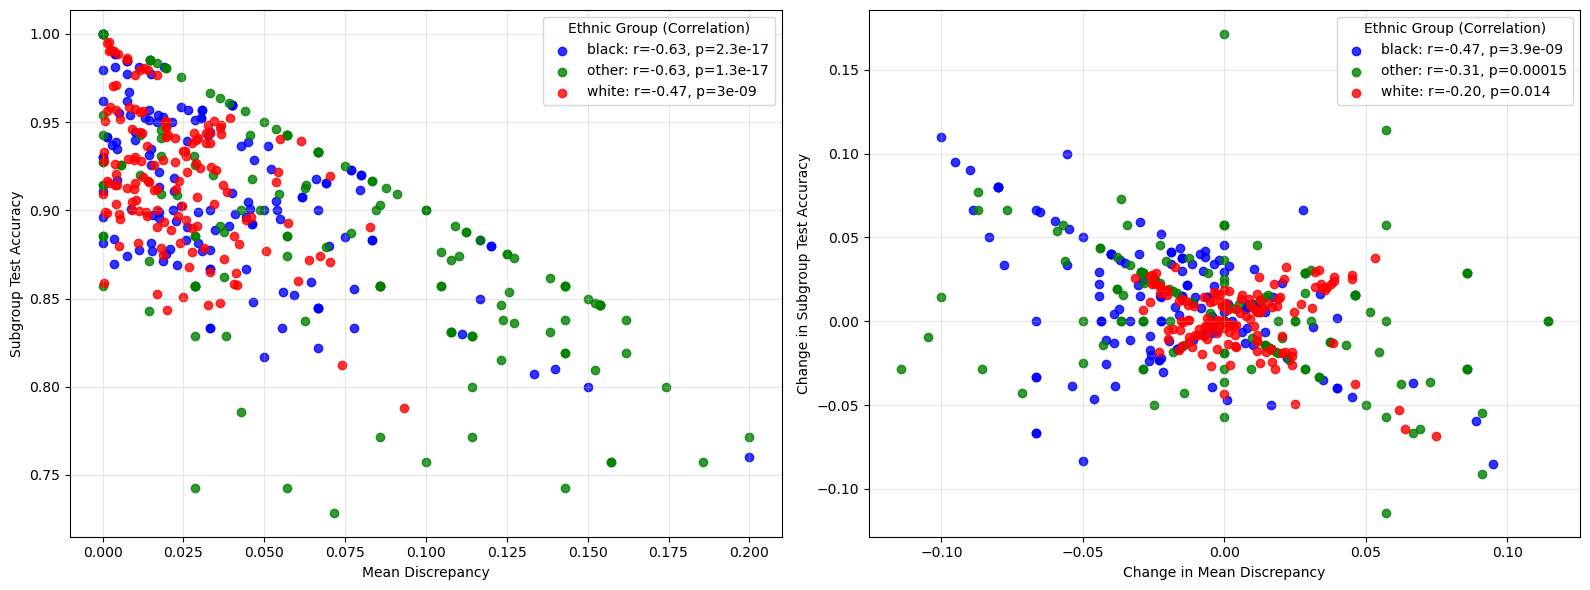

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Calculate values for both datasets
x_values_base = abs(df_base['pred_mean'] - df_base['true_mean'])
y_values_base = df_base.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

x_values_add = abs(df_add_results['pred_mean'] - df_add_results['true_mean'])
y_values_add = df_add_results.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

# Create filtered DataFrame for data addition (same as your second plot)
df_add_filtered = df_add_results.assign(
    x_values=x_values_add,
    y_values=y_values_add
).dropna(subset=['y_values'])

# For each point in df_add_filtered, find its corresponding point in df_base
# Match on hos_id == test_hos_id AND ethnic == ethnic
merged_df = df_add_filtered.merge(
    df_base[['hos_id', 'ethnic', 'pred_mean', 'true_mean'] + [f"{race_dict[race]}_{metric}" for race in ['black', 'other', 'white']]],
    left_on=['test_hos_id', 'ethnic'],
    right_on=['hos_id', 'ethnic'],
    suffixes=('_add', '_base'),
    how='left'
)

# Calculate base x and y values for the matched points
merged_df['x_base'] = abs(merged_df['pred_mean_base'] - merged_df['true_mean_base'])
merged_df['y_base'] = merged_df.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}_base"], axis=1)

# Calculate differences (Add - Base)
merged_df['x_diff'] = merged_df['x_values'] - merged_df['x_base']
merged_df['y_diff'] = merged_df['y_values'] - merged_df['y_base']

# Use merged_df as our final filtered dataset
df_add_filtered = merged_df

# Color mapping
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}
categories = df_add_filtered['ethnic'].unique()

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Data Addition results (your second plot)
for ethnic_group in categories:
    mask = df_add_filtered['ethnic'] == ethnic_group
    x_group = df_add_filtered.loc[mask, 'x_values']
    y_group = df_add_filtered.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points
    ax1.scatter(x_group, y_group, 
               label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", 
               color=colors[ethnic_group], alpha=0.8)

ax1.set_xlabel('Mean Discrepancy')
ax1.set_ylabel(f'Subgroup {format_metric[metric]}')
ax1.legend(title='Ethnic Group (Correlation)')
# ax1.set_title('Under Data Addition')
ax1.grid(True, alpha=0.3)

# Right plot: Difference plot (Data Addition - Base)
for ethnic_group in categories:
    mask = df_add_filtered['ethnic'] == ethnic_group
    x_diff = df_add_filtered.loc[mask, 'x_diff']
    y_diff = df_add_filtered.loc[mask, 'y_diff']
    
    # Compute correlation coefficient and p-value for differences
    if len(x_diff) > 1:
        corr_coef, p_val = pearsonr(x_diff, y_diff)
    else:
        corr_coef, p_val = float('nan'), float('nan')
    
    # Add scatter points
    ax2.scatter(x_diff, y_diff, 
               label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", 
               color=colors[ethnic_group], alpha=0.8)

ax2.set_xlabel('Change in Mean Discrepancy')
ax2.set_ylabel(f'Change in Subgroup Test Accuracy')
ax2.legend(title='Ethnic Group (Correlation)')
# ax2.set_title('Change: Data Addition - Base')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

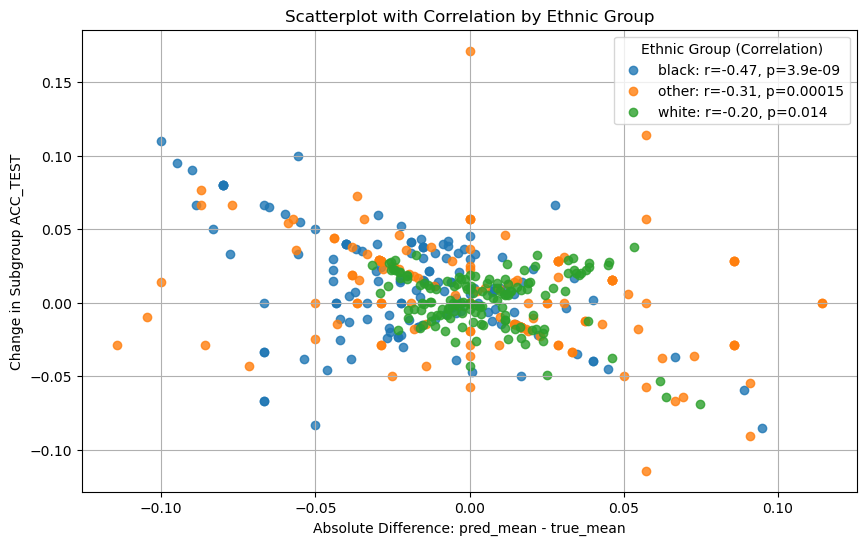

In [ ]:
metric = 'ACC_TEST'

df_filtered = df_add_results.merge(df_base, left_on=['test_hos_id', 'ethnic'], right_on=['hos_id', 'ethnic'], suffixes=[None, "_base"])

x_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])
x_values = abs(df_filtered['pred_mean'] - df_filtered['true_mean']) - x_values_base

y_values_base = df_filtered.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}_base"], axis=1)
y_values = df_filtered.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1) - y_values_base

# Create a filtered DataFrame with no NaN y_values
df_filtered = df_filtered.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

# Assign unique colors to each ethnic category
categories = df_filtered['ethnic'].unique()
colors = {cat: plt.cm.tab10(i) for i, cat in enumerate(categories)}

# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))

for ethnic_group in categories:
    # Mask for the current ethnic group
    mask = df_filtered['ethnic'] == ethnic_group
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points for the group
    plt.scatter(x_group, y_group, label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", color=colors[ethnic_group], alpha=0.8)

plt.xlabel('Absolute Difference: pred_mean - true_mean')
plt.ylabel(f'Change in Subgroup {metric}')
plt.legend(title='Ethnic Group (Correlation)')
plt.title('Scatterplot with Correlation by Ethnic Group')
plt.grid(True)
plt.show()

### Mean Consistency with Subgroup Data Addition

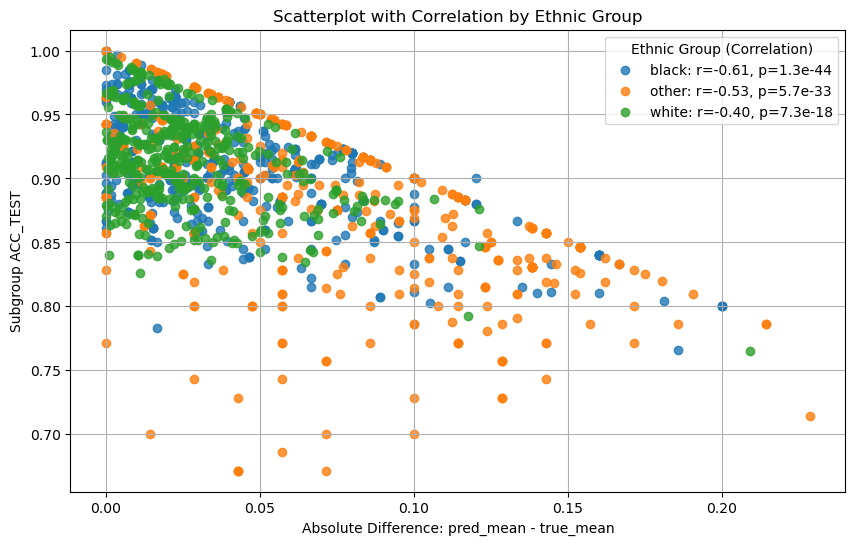

In [ ]:
metric = 'ACC_TEST'

x_values = abs(df_add_subg_results['pred_mean'] - df_add_subg_results['true_mean'])
y_values = df_add_subg_results.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1)

# Create a filtered DataFrame with no NaN y_values
df_filtered = df_add_subg_results.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

# Assign unique colors to each ethnic category
categories = df_filtered['ethnic'].unique()
colors = {cat: plt.cm.tab10(i) for i, cat in enumerate(categories)}

# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))

for ethnic_group in categories:
    # Mask for the current ethnic group
    mask = df_filtered['ethnic'] == ethnic_group
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points for the group
    plt.scatter(x_group, y_group, label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", color=colors[ethnic_group], alpha=0.8)

plt.xlabel('Absolute Difference: pred_mean - true_mean')
plt.ylabel(f'Subgroup {metric}')
plt.legend(title='Ethnic Group (Correlation)')
# plt.title('Scatterplot with Correlation by Ethnic Group')
plt.grid(True)
plt.show()

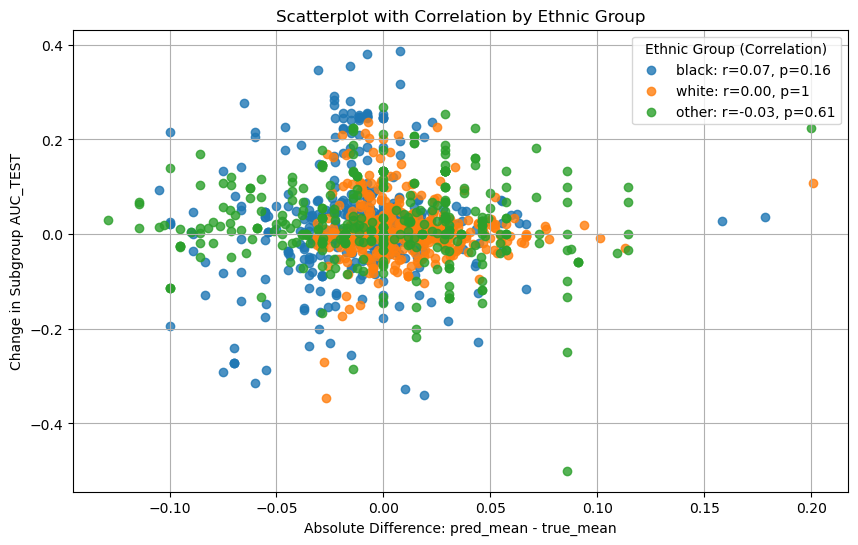

In [ ]:
metric = 'AUC_TEST'

df_filtered = df_add_subg_results.merge(df_base, left_on=['test_hos_id', 'ethnic'], right_on=['hos_id', 'ethnic'], suffixes=[None, "_base"])

x_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])
x_values = abs(df_filtered['pred_mean'] - df_filtered['true_mean']) - x_values_base

y_values_base = df_filtered.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}_base"], axis=1)
y_values = df_filtered.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1) - y_values_base

# Create a filtered DataFrame with no NaN y_values
df_filtered = df_filtered.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

# Assign unique colors to each ethnic category
categories = df_filtered['ethnic'].unique()
colors = {cat: plt.cm.tab10(i) for i, cat in enumerate(categories)}

# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))

for ethnic_group in categories:
    # Mask for the current ethnic group
    mask = df_filtered['ethnic'] == ethnic_group
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points for the group
    plt.scatter(x_group, y_group, label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", color=colors[ethnic_group], alpha=0.8)

plt.xlabel('Absolute Difference: pred_mean - true_mean')
plt.ylabel(f'Change in Subgroup {metric}')
plt.legend(title='Ethnic Group (Correlation)')
plt.title('Scatterplot with Correlation by Ethnic Group')
plt.grid(True)
plt.show()

## Mean Consistency without Predictor Mean

In [17]:
original_mu_f_test = df_base['pred_mean'] * 0.83333 
added_mu_train = df_base['true_mean'] * 0.16666


In [18]:
df_tmp = df_add_subg_results.merge(df_base[['hos_id', 'ethnic', 'pred_mean']], left_on=['test_hos_id', 'ethnic'], right_on=['hos_id', 'ethnic'], suffixes=[None, "_base"])
df_tmp = df_tmp.merge(df_base[['hos_id', 'ethnic', 'true_mean']], left_on=['train_hos_id', 'train_ethnic'], right_on=['hos_id', 'ethnic'], suffixes=[None, "_added"])

df_tmp.drop(['hos_id_added', 'hos_id', 'ethnic_added'], axis=1, inplace=True)

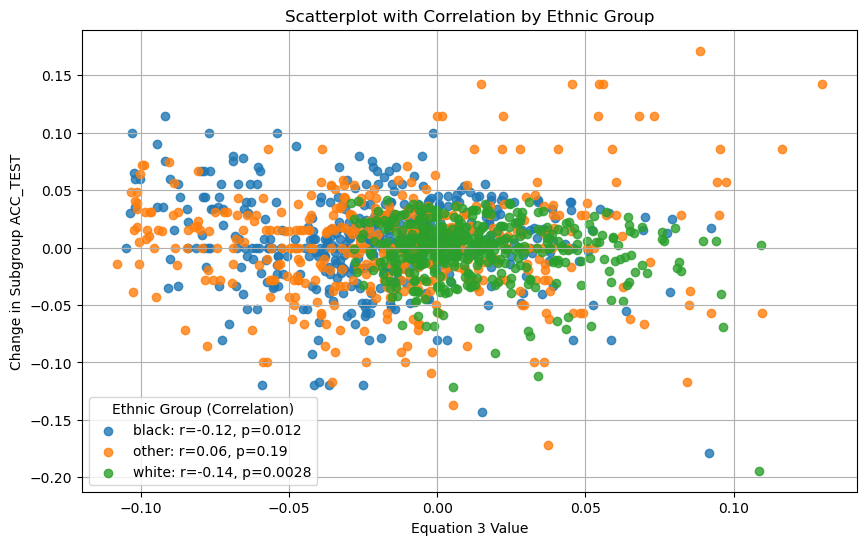

In [19]:
metric = 'ACC_TEST'

df_filtered = df_add_subg_results.merge(df_base, left_on=['test_hos_id', 'ethnic'], right_on=['hos_id', 'ethnic'], suffixes=[None, "_base"])

x_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])

df_counts = df_filtered.merge(df_race[['hosp_id', 'white_count', 'black_count', 'other_count']], left_on=['train_hos_id'], right_on=['hosp_id'])
counts = df_counts.apply(lambda row: row[f"{row['train_ethnic']}_count"], axis=1).apply(lambda n: min(1000, n))

# Compute the weighted average
weighted_avg = ((df_tmp['pred_mean_base'] * 1000) + (df_tmp['true_mean_added'] * counts)) / (1000 + counts)

x_values_add = abs(weighted_avg - df_filtered['true_mean'])
x_values = x_values_add - x_values_base

y_values_base = df_filtered.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}_base"], axis=1)
y_values = df_filtered.apply(lambda row: row[f"{race_dict[row['ethnic']]}_{metric}"], axis=1) - y_values_base

# Create a filtered DataFrame with no NaN y_values
df_filtered = df_filtered.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

# Assign unique colors to each ethnic category
categories = df_filtered['ethnic'].unique()
colors = {cat: plt.cm.tab10(i) for i, cat in enumerate(categories)}

# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))

for ethnic_group in categories:
    # Mask for the current ethnic group
    mask = df_filtered['ethnic'] == ethnic_group
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points for the group
    plt.scatter(x_group, y_group, label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", color=colors[ethnic_group], alpha=0.8)

plt.xlabel('Equation 3 Value')
plt.ylabel(f'Change in Subgroup {metric}')
plt.legend(title='Ethnic Group (Correlation)')
plt.title('Scatterplot with Correlation by Ethnic Group')
plt.grid(True)
plt.show()

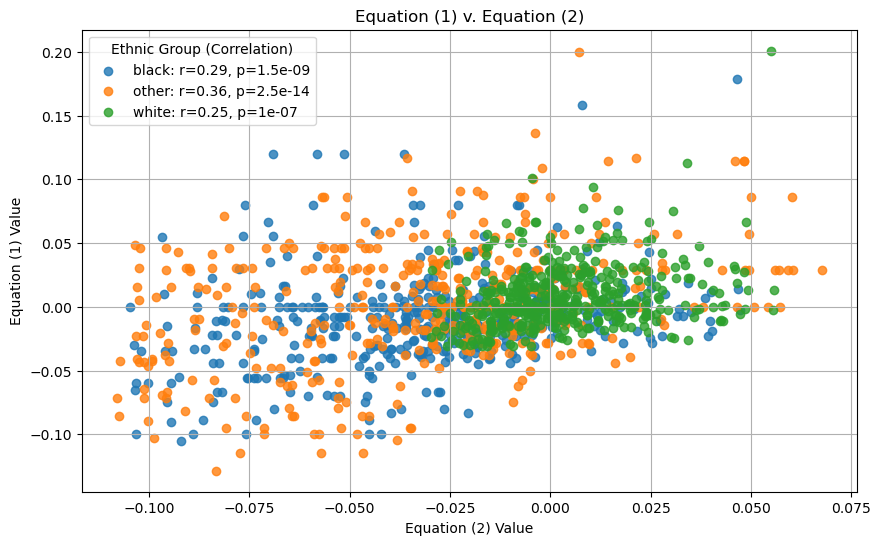

In [20]:
metric = 'AUC_TEST'

df_filtered = df_add_subg_results.merge(df_base, left_on=['test_hos_id', 'ethnic'], right_on=['hos_id', 'ethnic'], suffixes=[None, "_base"])

x_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])
x_values_add = abs((df_tmp['pred_mean_base'] * 0.5) + (df_tmp['true_mean_added'] * 0.5) - df_filtered['true_mean'])
x_values = x_values_add - x_values_base

y_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])
y_values = abs(df_filtered['pred_mean'] - df_filtered['true_mean']) - y_values_base

# Create a filtered DataFrame with no NaN y_values
df_filtered = df_filtered.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

# Assign unique colors to each ethnic category
categories = df_filtered['ethnic'].unique()
colors = {cat: plt.cm.tab10(i) for i, cat in enumerate(categories)}

# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))

for ethnic_group in categories:
    # Mask for the current ethnic group
    mask = df_filtered['ethnic'] == ethnic_group
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points for the group
    plt.scatter(x_group, y_group, label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", color=colors[ethnic_group], alpha=0.8)

plt.xlabel('Equation (2) Value')
plt.ylabel(f'Equation (1) Value')
plt.legend(title='Ethnic Group (Correlation)')
plt.title('Equation (1) v. Equation (2)')
plt.grid(True)
plt.show()

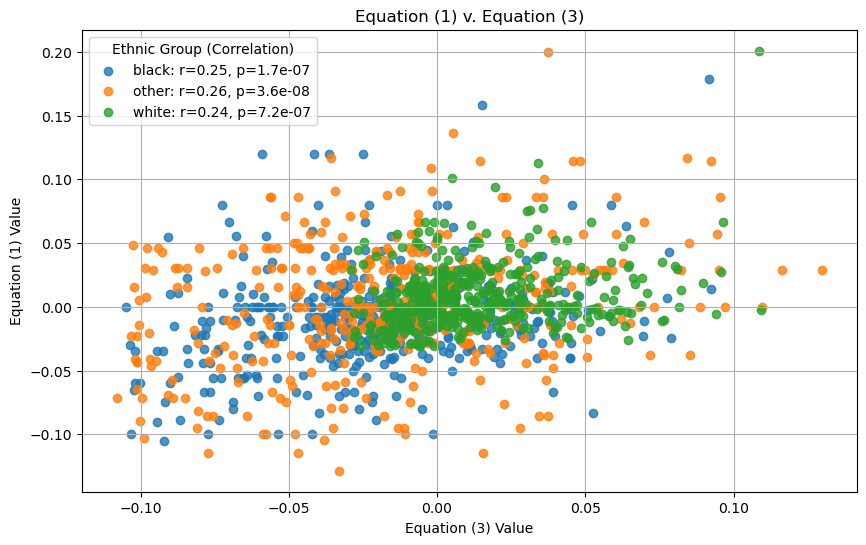

In [21]:
metric = 'AUC_TEST'

df_filtered = df_add_subg_results.merge(df_base, left_on=['test_hos_id', 'ethnic'], right_on=['hos_id', 'ethnic'], suffixes=[None, "_base"])

x_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])

df_counts = df_filtered.merge(df_race[['hosp_id', 'white_count', 'black_count', 'other_count']], left_on=['train_hos_id'], right_on=['hosp_id'])
counts = df_counts.apply(lambda row: row[f"{row['train_ethnic']}_count"], axis=1).apply(lambda n: min(1000, n))

# Compute the weighted average
weighted_avg = ((df_tmp['pred_mean_base'] * 1000) + (df_tmp['true_mean_added'] * counts)) / (1000 + counts)

x_values_add = abs(weighted_avg - df_filtered['true_mean'])
x_values = x_values_add - x_values_base

y_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])
y_values = abs(df_filtered['pred_mean'] - df_filtered['true_mean']) - y_values_base

# Create a filtered DataFrame with no NaN y_values
df_filtered = df_filtered.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

# Assign unique colors to each ethnic category
categories = df_filtered['ethnic'].unique()
colors = {cat: plt.cm.tab10(i) for i, cat in enumerate(categories)}

# Scatter plot with colors and calculate correlation coefficients
plt.figure(figsize=(10, 6))

for ethnic_group in categories:
    # Mask for the current ethnic group
    mask = df_filtered['ethnic'] == ethnic_group
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    corr_coef, p_val = pearsonr(x_group, y_group)
    
    # Add scatter points for the group
    plt.scatter(x_group, y_group, label=f"{ethnic_group}: r={corr_coef:.2f}, p={p_val:.2g}", color=colors[ethnic_group], alpha=0.8)

plt.xlabel('Equation (3) Value')
plt.ylabel(f'Equation (1) Value')
plt.legend(title='Ethnic Group (Correlation)')
plt.title('Equation (1) v. Equation (3)')
plt.grid(True)
plt.show()

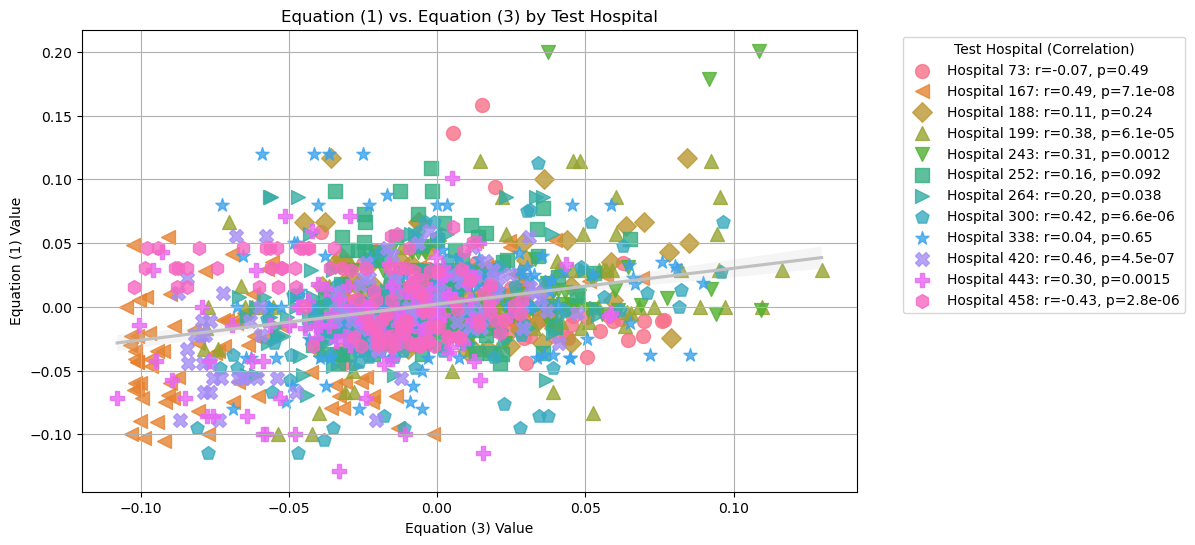

In [22]:
metric = 'ACC_TEST'

df_filtered = df_add_subg_results.merge(df_base, left_on=['test_hos_id', 'ethnic'], right_on=['hos_id', 'ethnic'], suffixes=[None, "_base"])

x_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])

df_counts = df_filtered.merge(df_race[['hosp_id', 'white_count', 'black_count', 'other_count']], 
                              left_on=['train_hos_id'], right_on=['hosp_id'])
counts = df_counts.apply(lambda row: row[f"{row['train_ethnic']}_count"], axis=1).apply(lambda n: min(1000, n))

# Compute the weighted average
weighted_avg = ((df_tmp['pred_mean_base'] * 1000) + (df_tmp['true_mean_added'] * counts)) / (1000 + counts)

x_values_add = abs(weighted_avg - df_filtered['true_mean'])
x_values = x_values_add - x_values_base

y_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])
y_values = abs(df_filtered['pred_mean'] - df_filtered['true_mean']) - y_values_base

# Create a filtered DataFrame with no NaN y_values
df_filtered = df_filtered.assign(
    x_values=x_values,
    y_values=y_values
).dropna(subset=['y_values'])

# Define 12 unique colors and markers for test_hos_id
test_hosp_ids = df_filtered['test_hos_id'].unique()
palette = sns.color_palette("husl", 12)  # 12 unique colors
markers = ['o', '<', 'D', '^', 'v', 's', '>', 'p', '*', 'X', 'P', 'h']  # 12 unique markers

# Map each test_hos_id to a color and marker
color_dict = {test_hosp_id: palette[i] for i, test_hosp_id in enumerate(test_hosp_ids)}
marker_dict = {test_hosp_id: markers[i] for i, test_hosp_id in enumerate(test_hosp_ids)}

plt.figure(figsize=(10, 6))
correlation_dict = {}

for test_hos_id in test_hosp_ids:
    mask = df_filtered['test_hos_id'] == test_hos_id
    x_group = df_filtered.loc[mask, 'x_values']
    y_group = df_filtered.loc[mask, 'y_values']
    
    # Compute correlation coefficient and p-value
    if len(x_group) > 1:
        corr_coef, p_val = pearsonr(x_group, y_group)
        correlation_dict[test_hos_id] = corr_coef
    else:
        corr_coef, p_val = np.nan, np.nan  # Not enough data points

    plt.scatter(x_group, y_group, 
                label=f"Hospital {test_hos_id}: r={corr_coef:.2f}, p={p_val:.2g}",
                color=color_dict[test_hos_id], 
                marker=marker_dict[test_hos_id], 
                alpha=0.8, s=100)

# Add regression line
sns.regplot(x='x_values', y='y_values', data=df_filtered, scatter=False, color='silver')

plt.xlabel('Equation (3) Value')
plt.ylabel(f'Equation (1) Value')
plt.legend(title='Test Hospital (Correlation)', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.title('Equation (1) vs. Equation (3) by Test Hospital')
plt.grid(True)
plt.show()


In [23]:
df_counts = df_filtered.merge(df_race[['hosp_id', 'white_count', 'black_count', 'other_count']], 
                              left_on=['train_hos_id'], right_on=['hosp_id'])
counts = df_counts.apply(lambda row: row[f"{row['train_ethnic']}_count"], axis=1).apply(lambda n: min(1000, n))

features = [df_filtered['pred_mean_base'], df_filtered['true_mean_base'], df_tmp['true_mean_added'], counts]

In [24]:
y_values_base = abs(df_filtered['pred_mean_base'] - df_filtered['true_mean_base'])
y_values = abs(df_filtered['pred_mean'] - df_filtered['true_mean']) - y_values_base

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Convert list of Series into a DataFrame
X = pd.concat(features, axis=1)
X.columns = [f'feature_{i}' for i in range(len(features))]  # Name the columns

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df_filtered['pred_mean'], test_size=0.2, random_state=42)

# Train a regression model
# regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.002197895751192228
